# Tutorial 4: Initializing a fine-scale chain

In [12]:
import sys
sys.path.append(r"/home/niyashao/3MC/geostatsMCMC/pck")

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import Topography
import MCMC
import gstatsim as gs

In [14]:
# only for development purpose
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load data first

In [4]:
# load compiled bed elevation measurements
df = pd.read_csv('DenmanDataGridded.csv')

In [5]:
# create a grid of x and y coordinates
x_uniq = np.unique(df.x)
y_uniq = np.unique(df.y)

xmin = np.min(x_uniq)
xmax = np.max(x_uniq)
ymin = np.min(y_uniq)
ymax = np.max(y_uniq)

cols = len(x_uniq)
rows = len(y_uniq)

resolution = 1000

xx, yy = np.meshgrid(x_uniq, y_uniq)

In [6]:
# load other data
dhdt = df['dhdt'].values.reshape(xx.shape)
smb = df['smb'].values.reshape(xx.shape)
velx = df['velx'].values.reshape(xx.shape)
vely = df['vely'].values.reshape(xx.shape)
bm_mask = df['bm_mask'].values.reshape(xx.shape)
bm_source = df['bm_source'].values.reshape(xx.shape)
bm_bed = df['bm_bed'].values.reshape(xx.shape)
surf = df['bm_surface'].values.reshape(xx.shape)
highvel_mask = df['highvel_mask'].values.reshape(xx.shape)

In [7]:
cond_bed = np.where(bm_mask == 2, df['bed'].values.reshape(xx.shape), bm_bed)
df['cond_bed'] = cond_bed.flatten()

range, sill, and nugget for gaussian variogram is  [32974.750379774654, 1.4030860598922286, 0]
for exponential variogram is  [56552.56038484651, 1.561238762812706, 0]
for spherical variogram is  [40085.32891370093, 1.4541673728039182, 0]
range, sill, smoothness, and nugget for for matern variogram is  [40853.58761626365, 1.498923813700147, 1.025412699356259, 0]


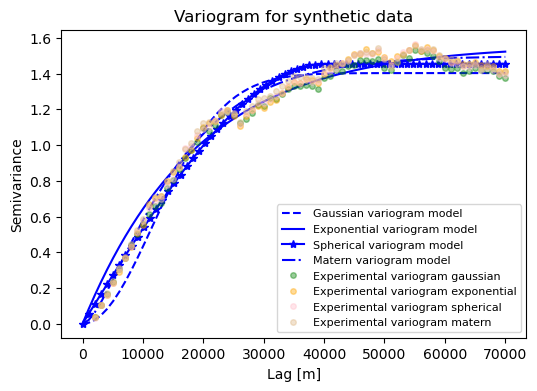

In [8]:
# find variograms
df_bed = df.copy()
df_bed = df_bed[df_bed["cond_bed"].isnull() == False]
data = df_bed['cond_bed'].values.reshape(-1,1)
coords = df_bed[['x','y']].values
roughness_region_mask = (df_bed['bm_mask'].values)==2 # Read BedMachine user guide for the meaning of values == 2 https://nsidc.org/data/nsidc-0756/versions/3

nst_trans, Nbed_radar, varios, fig = MCMC.fit_variogram(data, coords, roughness_region_mask, maxlag=70000, n_lags=70)

In [9]:
# load the initial bed, make sure no bed in grounded ice region is higher altitude than ice surface
sgs_bed = np.loadtxt('sgs_bed.txt')
thickness = surf - sgs_bed
sgs_bed = np.where((thickness<=0)&(bm_mask==2), surf-1, sgs_bed)

In [10]:
# initiate conditioning data and a mask of conditioning data
cond_bed = df['bed'].values.reshape(xx.shape)
data_mask = ~np.isnan(cond_bed)

### Then initiating the SGS chain

The first 4 initialization process are very similar to chain_crf, please refers to Tutorial 3 for detailed information

In [11]:
grounded_ice_mask = (bm_mask == 2)

In [16]:
csgs = MCMC.chain_sgs(xx, yy, sgs_bed, surf, velx, vely, dhdt, smb, cond_bed, data_mask, grounded_ice_mask, resolution)

before running the chain, please set where the block update will be using chainname.set_update_in_region(region_mask) and chainname.set_high_vel_region(update_in_region)
please also set up the sgs parameters using chainname.set_sgs_param(self, block_size, sgs_param)
then please set up the loss function using either chainname.set_loss_type or chainname.set_loss_func


In [17]:
csgs.set_high_vel_region(True,highvel_mask)

In [18]:
csgs.set_loss_type(map_func='sumsquare', sigma_mc=3, massConvInRegion=True)

In [19]:
# TODO: change this function to be consistent with crf chain
min_block_x = 10
max_block_x = 30
min_block_y = 10
max_block_y = 30
csgs.set_block_sizes(min_block_x, min_block_y, max_block_x, max_block_y)

Sequential Gaussian Simulation is set to perform on the normalized data. This nst_trans is an object of the QuantileTranformer class in scikit-learn python library. The *fit_variogram* function returns a nst_trans object, which could be directly used here

In [20]:
csgs.set_normal_transformation(nst_trans)

When running the SGS chain, it is possible to 'detrend' the topography.

Detrend topography refers to substracting a pre-defined trend from the topography map, where the trend suppose to represent long-wavelength features that violate stationary properties of SGS. If choose to detrend the topography, the argument *detrend_map* need to be set to True, and the argument *trend* need to be a 2D numpy array representing the topography trend

In [21]:
csgs.set_trend(trend = [], detrend_map = False)

In [24]:
varios

[[32974.750379774654, 1.4030860598922286, 0],
 [56552.56038484651, 1.561238762812706, 0],
 [40085.32891370093, 1.4541673728039182, 0],
 [40853.58761626365, 1.498923813700147, 1.025412699356259, 0]]

In [25]:
csgs.set_variogram('Matern',varios[3][0],varios[3][1],0,isotropic=True,vario_smoothness=varios[3][2])

the variogram is set to type Matern


In [27]:
csgs.set_sgs_param(48, 50e3, sgs_rand_dropout_on=False, dropout_rate=0.0)

because the sgs_rand_dropout_on is set to False, the dropout_rate is automatically set to 0


In [30]:
seed = 1
randomGenerator = np.random.default_rng(seed)
bed_cache, loss_mc_cache, loss_data_cache, loss_cache, step_cache, resampled_times, blocks_cache = csgs.run(n_iter=500, rng=randomGenerator)

i: 0 mc loss: 1.916e+06 loss: 1.916e+06 acceptance rate: 0.0


In [32]:
bed_cache.shape

(500, 200, 300)

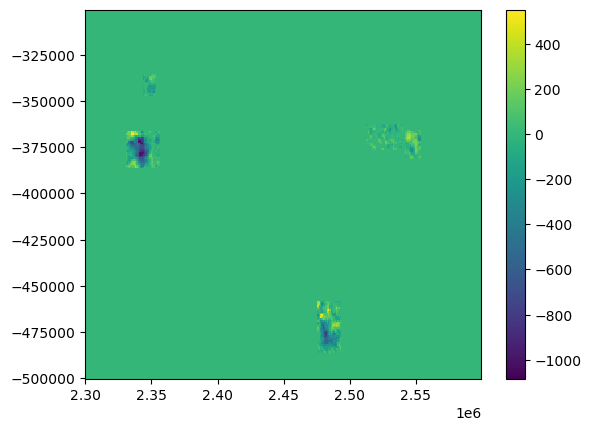

In [35]:
plt.pcolormesh(xx,yy,bed_cache[10]-bed_cache[0])
plt.colorbar()

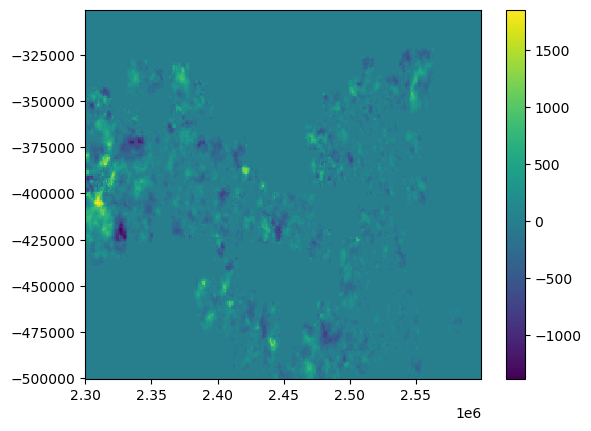

In [37]:
plt.pcolormesh(xx,yy,bed_cache[-1]-bed_cache[0])
plt.colorbar()

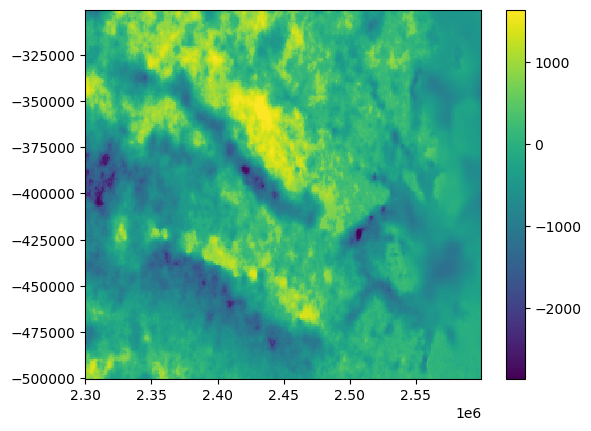

In [38]:
plt.pcolormesh(xx,yy,bed_cache[0])
plt.colorbar()

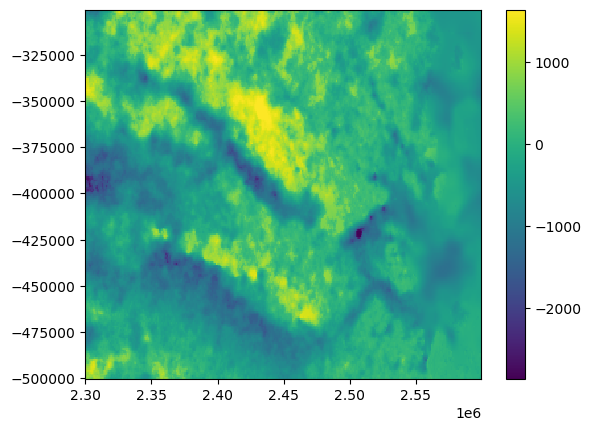

In [39]:
plt.pcolormesh(xx,yy,bed_cache[-1])
plt.colorbar()